In [2]:

import os
import pandas as pd
import numpy as np
import numpy.lib.recfunctions as rfn
from scipy.stats import skew, kurtosis

from io import StringIO
import time

import matplotlib.pyplot as plt
from datetime import datetime, date

from tkinter import filedialog
import tkinter as tk
from tqdm import tqdm
import glob

import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import natsort

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.svm import SVR

import seaborn as sns

import http.client
import json

import os
import re
from tqdm import tqdm
from datetime import datetime

#from gps_parameters import GpsConverter1

In [3]:
def calibration(raw_df):

    def int_to_datetime(integer):
        try:
            str_dt = str(integer).zfill(6)  # 입력값이 짧으면 앞에 0을 추가
            result_dt = datetime.strptime(str_dt, '%H%M%S')  # 시간 형식으로 변환
            result_unix = result_dt.timestamp()  # 유닉스 타임스탬프로 변환
            return result_unix
        except ValueError as e:
            print(f"ValueError: {integer} is not a valid time format.")
            raise e

    def foam2(base, target):
        r1,c1 = base.shape
        r2,c2 = target.shape
        N = c1
        H = c1//2
        pC1 = np.mean(base[:,0:H],1)
        qC1 = np.mean(target[:,0:H],1)
        pC2 = np.mean(base[:,H:c1],1)
        qC2 = np.mean(target[:,H:c1],1)
        pC1 = pC1.reshape(-1,1)
        qC1 = qC1.reshape(-1,1)
        pC2 = pC2.reshape(-1,1)
        qC2 = qC2.reshape(-1,1)

        pp = np.zeros((r1,c1))
        pp[:,0:H] = base[:,0:H] - pC1
        pp[:,H:c1] = base[:,H:c1] - pC2
        qp = np.zeros((r2,c2))
        qp[:,0:H] = target[:,0:H] - qC1
        qp[:,H:c1] = target[:,H:c1] - qC2
        B = qp.dot(pp.T)
        detB = np.linalg.det(B)
        froBsq = (np.linalg.norm(B,'fro'))**2
        invB = np.linalg.inv(B)
        adjB = detB *invB
        froadjBsq = np.linalg.norm(adjB,'fro')**2
        lam = 0.5*(np.sum(qp**2)+np.sum(pp**2))
        lamprev = 0.0
        while abs((lam-lamprev)/lam) >= 1e-12:
            lamprev = lam
            tmp = lam**2 - froBsq
            lam = lam - (tmp**2 - 8*lam*detB - 4*froadjBsq)/(4*tmp*lam - 8*detB)
        R = ((lam**2 + froBsq)*B + 2*lam*adjB.T - 2*np.matmul(B,np.matmul(B.T,B))) / (lam*(lam**2 - froBsq) - 2*detB)
        t1 = qC1 - np.matmul(R, pC1)
        t2 = qC2 - np.matmul(R, pC2)
        pp = np.zeros((r1,c1))
        pp[:,:H] += np.matmul(R,base)[:,:H] + t1
        pp[:,H:] += np.matmul(R,base)[:,H:] + t2
        err = np.mean(np.sqrt(np.sum((target-pp)**2,1)))
        return R,t1,t2,err

    def foam(base, target):
        r1,c1 = base.shape
        r2,c2 = target.shape

        pC = np.mean(base[:,:],1)
        qC = np.mean(target[:,:],1)
        pC = pC.reshape(-1,1)
        qC = qC.reshape(-1,1)

        pp = np.zeros((r1,c1))
        pp[:,:] = base[:,:] - pC
        qp = np.zeros((r2,c2))
        qp[:,:] = target[:,:] - qC
        B = qp.dot(pp.T)
        detB = np.linalg.det(B)
        froBsq = (np.linalg.norm(B,'fro'))**2
        try:
            invB = np.linalg.inv(B)
        except Exception as e:
            raise e
            return False, False, False
        invB = np.linalg.inv(B)
        adjB = detB *invB
        froadjBsq = np.linalg.norm(adjB,'fro')**2
        lam = 0.5*(np.sum(qp**2)+np.sum(pp**2))
        lamprev = 0.0
        while abs((lam-lamprev)/lam) >= 1e-12:
            lamprev = lam
            tmp = lam**2 - froBsq
            lam = lam - (tmp**2 - 8*lam*detB - 4*froadjBsq)/(4*tmp*lam - 8*detB)
        R = ((lam**2 + froBsq)*B + 2*lam*adjB.T - 2*np.matmul(B,np.matmul(B.T,B))) / (lam*(lam**2 - froBsq) - 2*detB)
        t1 = qC - np.matmul(R, pC)
        pp = np.zeros((r1,c1))
        pp[:,:] += np.matmul(R,base)[:,:] + t1
        err = np.mean(np.sqrt(np.sum((target-pp)**2,1)))
        return R,t1,err

    def movmean(lst, window):
        return np.convolve(lst, np.ones(window)/window, mode='same')

    def get_pseudo_acc(timestamp, gps_speed, gps_heading):
        #timestamp_seconds = timestamp.astype('int64') / 1e9
        if gps_heading[0] == None:
            gps_heading[0] = gps_heading.copy()[1]
        gps_speed_ms = gps_speed/3.6
        #gps_heading_tmp = np.deg2rad(gps_heading)
        gps_heading_rad = np.unwrap(gps_heading)
        pgyrZ = np.convolve(np.gradient(-gps_heading_rad)/np.gradient(timestamp), np.ones(10)/10, mode='same')
        paccX = np.gradient(gps_speed_ms)/np.gradient(timestamp)
        paccY = pgyrZ * gps_speed_ms
        return paccX, paccY, pgyrZ


    def static_imu_align(data, use_gyro = False, speed_thres = 5):
        #display(data)
        data = data.copy()
        # mask = np.where((data['numSV']<satellite_thres) | (data['Speed']<=speed_thres))
        mask = np.where((data['Speed']/3.6<=speed_thres))

        pseudo_acc_x, pseudo_acc_y, pseudo_gyr_z = get_pseudo_acc(data["TimeStamp"], data['Speed'], data['Heading'])
        pseudo_acc_z = np.ones(len(pseudo_gyr_z))*9.816
        pseudo_gyr_x = np.zeros(len(pseudo_gyr_z))
        pseudo_gyr_y = np.zeros(len(pseudo_gyr_z))

        pseudo_acc_x[mask] = 0
        pseudo_acc_y[mask] = 0
        pseudo_acc_z[mask] = 0
        pseudo_gyr_z[mask] = 0

        raw_acc_x = movmean(data['AccelX'],20)
        raw_acc_y = movmean(data['AccelY'],20)
        raw_acc_z = movmean(data['AccelZ'],20)
        raw_gyr_x = movmean(data['AngleRateX'],20)
        raw_gyr_y = movmean(data['AngleRateY'],20)
        raw_gyr_z = movmean(data['AngleRateZ'],20)

        raw_acc_x[mask] = 0
        raw_acc_y[mask] = 0
        raw_acc_z[mask] = 0
        raw_gyr_x[mask] = 0
        raw_gyr_y[mask] = 0
        raw_gyr_z[mask] = 0

        if use_gyro:

            # R*base + bias = target
            base = np.hstack((np.vstack((raw_acc_x, raw_acc_y, raw_acc_z)), np.rad2deg(np.vstack((raw_gyr_x, raw_gyr_y, raw_gyr_z)))))
            target = np.hstack((np.vstack((pseudo_acc_x, pseudo_acc_y, pseudo_acc_z)), np.rad2deg(np.vstack((pseudo_gyr_x, pseudo_gyr_y, pseudo_gyr_z)))))

            rotmat, bias_acc, bias_gyr, err = foam2(base, target)

        else:
            base = np.vstack((raw_acc_x, raw_acc_y, raw_acc_z))
            target = np.vstack((pseudo_acc_x, pseudo_acc_y, pseudo_acc_z))

            rotmat, bias_acc, err = foam(base, target)
            bias_gyr = np.mean(np.deg2rad(np.vstack((raw_gyr_x[mask], raw_gyr_y[mask], raw_gyr_z[mask]))), axis = 1)

        return (rotmat, bias_acc, np.deg2rad(bias_gyr), err)

    df = raw_df.copy()
    df = df.loc[(df["numSV"] > 5) & (df["Speed"] > 3)].copy()
    # Remove duplicate time for cali
    # df.drop_duplicates(subset=['datetime'], inplace=True)
    #df['unixtime'] = list(map(lambda x: int_to_datetime(x), df.index))

    # KEY MATCHING for Smartlink
    df["TimeStamp"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df["UnixTime"] = df["TimeStamp"].apply(lambda x: x.timestamp())
    data = np.array([tuple(x) for x in np.vstack( \
                # (df_N088_filtered['iTOW']/1000.0, \
                (df['UnixTime'], \
                    df['numSV'], \
                    df['Speed'], \
                    df['AccelX'], \
                    df['AccelY'], \
                    df['AccelZ'], \
                    df['AngleRateX'], \
                    df['AngleRateY'], \
                    df['AngleRateZ'], \
                    df["headMot"]
                    )).T], \
                    # df_sk_filtered['lat'], \
                    # df_sk_filtered['lon'])).T], \
                dtype = [('TimeStamp', None), \
                        ('numSV', None), \
                        ('Speed', None), \
                        ('AccelX', None), \
                        ('AccelY', None), \
                        ('AccelZ', None), \
                        ('AngleRateX', None), \
                        ('AngleRateY', None), \
                        ('AngleRateZ', None), \
                        ('Heading', None),
                        ])
                        # ('Latitude', None), \
                        # ('Longitude', None)])

    # RUN CALIBRATION
    try:
        rotmat, bias_acc, bias_gyr, err = static_imu_align(data, use_gyro=True)
        #display(rotmat)
        cal_acc = np.matmul(rotmat, np.vstack((raw_df['AccelX'], raw_df['AccelY'], raw_df['AccelZ']))) + bias_acc.reshape(3,1)
        cal_gyr = np.matmul(rotmat, np.vstack((raw_df['AngleRateX'], raw_df['AngleRateY'], raw_df['AngleRateZ']))) + bias_gyr.reshape(3,1)
    except Exception as e:
        print(e)
        raise e

    import time
    try:
        cal_name = "cal"
        raw_df['AccelX'] = cal_acc[0]
        raw_df['AccelY'] = cal_acc[1]
        raw_df['AccelZ'] = cal_acc[2]
        raw_df[f'AngleRateX'] = cal_gyr[0]
        raw_df[f'AngleRateY'] = cal_gyr[1]
        raw_df[f'AngleRateZ'] = cal_gyr[2]
    except Exception as e:
        print(e)
        raw_df = rfn.append_fields(raw_df,'AccelX', cal_acc[0])
        raw_df = rfn.append_fields(raw_df,'AccelY', cal_acc[1])
        raw_df = rfn.append_fields(raw_df,'AccelZ', cal_acc[2])
        raw_df = rfn.append_fields(raw_df,'GyroX', cal_gyr[0])
        raw_df = rfn.append_fields(raw_df,'GyroY', cal_gyr[1])
        raw_df = rfn.append_fields(raw_df,'GyroZ', cal_gyr[2])
        raise e
    return raw_df

In [4]:

def detection(data, s_dist=200, e_dist = 150, numSV_ths = 10):
    data_outage = data.loc[data["numSV"] == 0]

    def group_consecutive(data):
     return np.split(data, np.where(np.diff(data.index) != 1)[0] + 1)

    data_outage_split = group_consecutive(data_outage)

    def filter_outage_sections(data_outage_split, speed_col="Speed", threshold=0.7):
        """
        주어진 리스트에서 정지 인덱스가 전체의 70% 이상인 섹션을 제거.
        """
        filtered_sections = []
        for outage_section in data_outage_split:
            zero_vel_index = outage_section.loc[(outage_section[speed_col] < 1)].index
            if len(zero_vel_index) <= threshold * len(outage_section):
                filtered_sections.append(outage_section)
        return filtered_sections

    data_outage_split = filter_outage_sections(data_outage_split)
    # 여기에서 시작 끝 점 기준으로 특정 인덱스 범위만큼 더 간 값들까지 붙여서 반환

    for idx, outage_section in enumerate(data_outage_split):

        s_i, o_i = outage_section.index[0], outage_section.index[-1]
        print(s_i, o_i)

        p_si, p_oi = data.loc[s_i - 10], data.loc[o_i + 10]

        try:
            s_o = s_i - int(s_dist/p_si["Speed"])
        except Exception as e:
            print("zero speed, detect as default distance")
            s_o = s_i - 7

        try:
            o_o = o_i + int(e_dist/p_oi["Speed_175"])
        except Exception as e:
            print("zero speed, detect as default distance")
            o_o = o_i + 5

        not_sat_s = True
        while not_sat_s:
            if (data.loc[s_o]["numSV"] > numSV_ths) and (data.loc[o_o]["numSV"] > numSV_ths):
                not_sat_s = False
            else:
                if (data.loc[s_o]["numSV"] <= numSV_ths) :
                    s_o = s_o - 1
                if (data.loc[o_o]["numSV"] <= numSV_ths):
                    o_o = o_o + 1


        outage_section_fin = pd.concat([data.loc[s_o:s_i], outage_section, data.loc[o_i + 1: o_o + 1]], axis = 0)

        data_outage_split[idx] = outage_section_fin

    return data_outage_split

pio.renderers.default = "browser"

acc_file = pd.read_csv(fr"C:\Users\양준원\PycharmProjects\DPS_GPS_Outage\20240909.csv").drop(columns=["Unnamed: 0"])
acc_file = calibration(acc_file)

result = detection(acc_file.loc[:5000])

# for outage_file in result:
#     #display(outage_file.describe(include="all"))
#     fig = px.scatter_mapbox(outage_file, lat = f'lat', lon= f'lon', color= f"headMot", zoom=15, mapbox_style='open-street-map', color_continuous_scale='turbo').update_traces(marker={'size':5})
#     fig.update_layout(
#         width = 1200,
#         height = 900,
#         margin = dict(l=0, r=0, t=0, b=0),
#     )
#     fig.show()


214 229
zero speed, detect as default distance
403 422
zero speed, detect as default distance
1667 1685
zero speed, detect as default distance
2237 2261
zero speed, detect as default distance


C:\Users\양준원\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



In [ ]:
from pyproj import Geod

# 이미 calibration 된 데이터에서 initailize한 한부분을 df로 받음
def initialize(df, linear_slope=False, reverse = False):

    df["TimeStamp"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df["UnixTime"] = df["TimeStamp"].apply(lambda x: x.timestamp())

    data = np.array([tuple(x) for x in np.vstack( \
                (df['UnixTime'], \
                    df['numSV'], \
                    df['height'], \
                    df['Speed'], \
                    df['AccelX'], \
                    df['AccelY'], \
                    df['AccelZ'], \
                    df['AngleRateX'], \
                    df['AngleRateY'], \
                    df['AngleRateZ'], \
                    df["headMot"], \
                    df["lat"], \
                    df["lon"],
                    )).T], \

                dtype = [('TimeStamp', None), \
                        ('numSV', None), \
                        ('Height', None), \
                        ('Speed', None), \
                        ('AccelX', None), \
                        ('AccelY', None), \
                        ('AccelZ', None), \
                        ('AngleRateX', None), \
                        ('AngleRateY', None), \
                        ('AngleRateZ', None), \
                        ('Heading', None),  \
                        ('Lat', None), \
                        ('Lon', None),
                        ])

    # 변화량은 소문자로 표기, 합친 값은 대문자로 표기기
    delta_p = {
        "heading": np.zeros(len(data)),
        "slope" :  np.zeros(len(data)),
        "speed" :  np.zeros(len(data)),
        "height" :  np.zeros(len(data)),
        "radius" :  np.zeros(len(data)),
    }

    # 원통형 좌표계로 start_point, end_point 변환

    geod = Geod(ellps="WGS84")

    time_delta = np.diff(data["TimeStamp"])
    time_delta = np.insert(time_delta, 0, time_delta[0])

    dt = data.dtype.descr.copy()
    dt.append(('Slope', '<f8'))
    dt.append(('Radius', '<f8'))
    dt.append(('Theta', '<f8'))

    start_point = data[0].copy()
    end_point = data[-1].copy()

    start_point = np.zeros(1, dtype=dt)[0]
    end_point = np.zeros(1, dtype=dt)[0]

    for name in data.dtype.names:
        start_point[name] = data[name][0]
        end_point[name] = data[name][-1]

    start_point["Slope"] = np.arctan2((data["Height"][1] - data["Height"][0]), (data["Speed"][0] * time_delta[0]))
    end_point["Slope"] = np.arctan2((data["Height"][-1] - data["Height"][-2]), (data["Speed"][-1] * time_delta[-1]))

    azimuth, _, distance = geod.inv(start_point["Lon"], start_point["Lat"], end_point["Lon"], end_point["Lat"])

    start_point["Radius"] = 0
    end_point["Radius"] = distance
    start_point["Theta"] = 0
    end_point["Theta"] =  end_point["Heading"] - start_point["Heading"]

    # initialize 하기 전에 각속도는 일단 MA 쳐야함. 마지막의 None 값은 data의 값 그대로 사용
    window_size_yaw = 1
    window_size_pitch = 10

    def ma_concat(data, ma, window_size):
        data_MA = np.full(len(data), np.nan)

        # 시작과 끝 부분 처리
        data_MA[-(window_size):] = data[-(window_size):] / window_size
        data_MA[:-(window_size)] = ma[:-(window_size)]

        return data_MA
    # Heading diff = - Yaw Rate, window 1로 그대로 사용
    Yaw_MA = -np.roll(df["AngleRateZ"].rolling(window_size_yaw).mean(), -window_size_yaw).copy()
    # Slope ~ Pitch Rate
    Pitch_MA = np.roll(df["AngleRateY"].rolling(window_size_pitch).mean(), -window_size_pitch).copy() / window_size_pitch

    Yaw_MA = ma_concat(data["AngleRateZ"], Yaw_MA, window_size_yaw)
    Pitch_MA = ma_concat(data["AngleRateY"], Pitch_MA, window_size_pitch)
    Accx_MA = data["AccelX"].copy()

    if reverse:
        start_point, end_point = end_point.copy(), start_point.copy()

        start_point["Radius"] = 0
        end_point["Radius"] = distance
        start_point["Theta"] = 0
        end_point["Theta"] =  - (end_point["Heading"] - start_point["Heading"])

        for point in [start_point, end_point]:
            point["Heading"] = point["Heading"] - np.pi
            point["Slope"] = - point["Slope"]
            point["Theta"] = - point["Theta"]
            # display(point[["Heading", "Slope"]])

        Yaw_MA = np.flip(Yaw_MA)
        Pitch_MA = np.flip(Pitch_MA)
        Accx_MA = np.flip(Accx_MA)
        time_delta = np.flip(time_delta)

    # display("pitch", Pitch_MA)
    # display("yaw", Yaw_MA)
    # display(time_delta)
    # display(Accx_MA)

    def init_heading(heading_array, Yaw_MA, time_delta):
        heading_array[:] = Yaw_MA/100 * time_delta
        if reverse:
            heading_array[:] = - Yaw_MA/100 * time_delta
        return heading_array

    def init_slope(slope_array, Pitch_MA, time_delta):
        slope_array[:] = Pitch_MA #* time_delta
        if reverse:
            slope_array[:] = - Pitch_MA #* time_delta
        slope_array = np.diff(slope_array)
        slope_array = np.insert(slope_array, 0, 0)

        return slope_array

    def init_speed(start_point, speed_array, Accx_MA, slope_array, time_delta):
        Slope_array = start_point["Slope"] + np.cumsum(slope_array)
        speed_array[:] = (Accx_MA - 9.814 * np.sin(Slope_array)) * np.cos(Slope_array) * time_delta

        if reverse:
            Slope_array = np.arctan2(end_point["Height"] - start_point["Height"], start_point["Speed"] * np.sum(time_delta)) + np.cumsum(slope_array)
            speed_array[:] = - (Accx_MA - 9.814 * np.sin(-Slope_array)) * np.cos(-Slope_array) * time_delta

        return speed_array

    def init_height(start_point, height_array, speed_array, slope_array, time_delta):

        Slope_array = start_point["Slope"] + np.cumsum(slope_array)
        Speed_array = start_point["Speed"] + np.cumsum(speed_array)
        height_array[:] = Speed_array * np.tan(Slope_array) * np.abs(time_delta)

        if reverse:
            Slope_array = np.arctan2(end_point["Height"] - start_point["Height"], start_point["Speed"] * np.sum(time_delta)) + np.cumsum(slope_array)
            Speed_array = start_point["Speed"] + np.cumsum(speed_array)
            height_array[:] = Speed_array * np.tan(Slope_array) * time_delta


        return height_array

    def init_radius(start_point, radius_array, speed_array, heading_array, time_delta):
        if not reverse:
            Speed_array = start_point["Speed"] + np.cumsum(speed_array)
        else:
            Speed_array = start_point["Speed"] + np.cumsum(speed_array)

        radius_array[:] = Speed_array * np.cos(heading_array) * time_delta
        return radius_array

    def now_value(array, idx):
        sum_array = array.cumsum()
        return sum_array[idx]

    delta_p["heading"] = init_heading(delta_p["heading"], Yaw_MA, time_delta)

     # 단순 끝점 간 고도 차로 linear 하게 초기 slope 생성, delta slope는 전부 0으로 초기화. slope_s를 해당 slope 값으로 설정
    if linear_slope == True:
        delta_p["slope"] = np.diff(np.linspace(start_point["Slope"], start_point["Slope"], len(data)))
        delta_p["slope"] = np.insert(delta_p["slope"], 0, 0)
        if reverse:
            delta_p["slope"] = np.diff(np.linspace(start_point["Slope"], start_point["Slope"], len(data)))
            delta_p["slope"] = np.insert(delta_p["slope"], 0, 0)
    else:
        delta_p["slope"] = init_slope(delta_p["slope"], Pitch_MA, time_delta)
    delta_p["speed"] = init_speed(start_point, delta_p["speed"], Accx_MA, delta_p["slope"], time_delta)
    delta_p["height"] = init_height(start_point, delta_p["height"], delta_p["speed"], delta_p["slope"], time_delta)
    delta_p["radius"] = init_radius(start_point, delta_p["radius"], delta_p["speed"], delta_p["heading"], time_delta)


    return start_point, end_point, delta_p

def bi_direction(s, e, delta_p, delta_r):
    # 양방향으로 초기 값 생성하고, 내분해서 최종 초기화



    pass

s, e, delta_p = initialize(result[0], linear_slope=False)
ss, ee, delta_r = initialize(result[0], reverse=True, linear_slope=True)

%matplotlib inline
def visuallize(s, e, delta_p):

    for col, delta_col in zip(["Height", "Speed", "Heading", "Slope", "Radius"],
                ["height", "speed", "heading", "slope", "radius"]):
        print(col, "diff as", e[col] - s[col], " ", "estimated as", np.sum(delta_p[delta_col]))

    display("start", f"heading : {s['Heading']}", f"radius : {s['Radius']}", f"height : {s['Height']}", f"slope : {s['Slope']}", f"speed : {s['Speed']}",)
    display("end", f"heading : {e['Heading']}", f"radius : {e['Radius']}", f"height : {e['Height']}", f"slope : {e['Slope']}", f"speed : {e['Speed']}",)
    display("estimated end", f"heading : {s['Heading'] + np.sum(delta_p['heading'])}", f"radius : {s['Radius'] + np.sum(delta_p['radius'])}", f"height : {s['Height']+ np.sum(delta_p['height'])}", f"slope : {s['Slope']+ np.sum(delta_p['slope'])}", f"speed : {s['Speed']+ np.sum(delta_p['speed'])}",)

    theta = np.cumsum(delta_p["heading"]) + s["Heading"]
    radius = np.cumsum(delta_p["radius"]) + s["Radius"]
    height = np.cumsum(delta_p["height"]) + s["Height"]

    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z = height

    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, label='Path')

    ax.scatter(s["Radius"] * np.cos(s["Heading"]),
            s["Radius"] * np.sin(s["Heading"]),
            s["Height"],
            color='red', s=100, label='Start Point')
    ax.scatter(e["Radius"] * np.cos(e["Heading"]),
            e["Radius"] * np.sin(e["Heading"]),
            e["Height"],
            color='blue', s=100, label='End Point')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Height')
    ax.set_title('Cylindrical Coordinate 3D')
    ax.legend()

    az = fig.add_subplot(122)

    az.scatter(x, y, label='Path')
    az.scatter(s["Radius"] * np.cos(s["Heading"]),
            s["Radius"] * np.sin(s["Heading"]), color='red', s=100, label='Start Point')
    az.scatter(e["Radius"] * np.cos(e["Heading"]),
            e["Radius"] * np.sin(e["Heading"]), color='blue', s=100, label='End Point')
    az.set_title('Cylindrical Coordinate 2D')
    az.set_xlabel('X')
    az.set_ylabel('Y')
    plt.show()

visuallize(s, e, delta_p)
visuallize(ss, ee, delta_r)

- 경사도의 경우 그냥 시작, 끝 점 고도 기준으로 linear 하게 생성하는 게 훨씬 나음. x 거리가 문제인데, 이를 시작점 기준 속력 * 전체 이동 시간, 끝점 기준 속력 * 전체 이동시간을 각 방향에 대해 적용시켜서 내분해 해결
- 내분점 코드에서 끝점 기준으로 생성한 각 점의 좌표를 결국 시작점 기준으로 변환하는 과정 필요함. 아니면 delta 자체를 내분..?

{'heading': array([-0.00191801,  0.00191801,  0.00287228, -0.00228198, -0.00090276,
         0.0044276 ,  0.00153371,  0.00579727,  0.00985271,  0.00808014,
         0.00841563,  0.0072244 ,  0.00720594,  0.01083011,  0.00884563,
         0.01007013,  0.01082384,  0.00867612,  0.00785928,  0.00694422,
         0.010869  ,  0.01264389,  0.01237519,  0.00994066,  0.01012031,
         0.        ,  0.00859518,  0.00859518,  0.00718757,  0.00809952,
         0.00900908,  0.00991935,  0.01129703]),
 'slope': array([ 0.00000000e+00, -2.66576004e-02, -1.46959828e-02,  1.00742808e-02,
         5.36368406e-02, -4.62457851e-02,  3.20680227e-03, -2.18461767e-02,
         1.10409878e-02,  1.66396077e-02, -6.18936617e-03, -1.62610986e-03,
         8.92873911e-04,  1.91670056e-03, -4.75446954e-04, -1.83570546e-03,
        -3.28359600e-04, -9.50738449e-04,  1.50019234e-03,  2.09442723e-03,
        -1.19436198e-03, -6.70399830e-04,  4.58269696e-04, -1.37297084e-03,
         1.25295094e-03, -9.73835628e

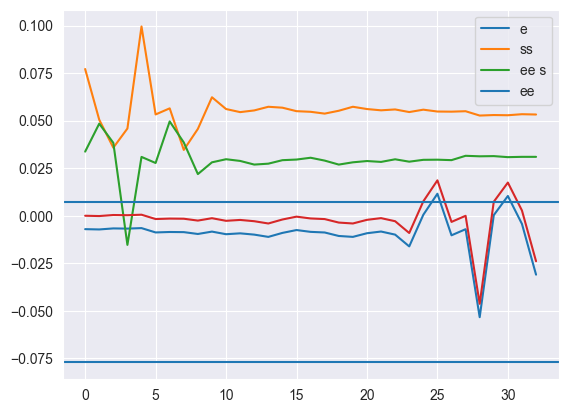

In [48]:
display(delta_r)

np.sum(delta_r["slope"])

plt.plot(np.cumsum(delta_p["slope"]) + s["Slope"])
plt.axhline(e["Slope"], label="e")
plt.plot(np.cumsum(delta_r["slope"]) + ss["Slope"], label="ss")
plt.plot(-np.cumsum(delta_p["slope"][::-1]) + ee["Slope"], label="ee s")
plt.plot(np.cumsum(delta_p["slope"]))
plt.axhline(ee["Slope"], label="ee")
plt.legend()